# Add feature sets that are collations of other feature sets into families.

The purpose of this notebook is to append feature sets that are defined by collating other feature sets.

This notebook is expected to be called by its parent `UNSEEN_create_feature_sets.ipynb`. It will not run without the requisite loaded during the parent notebook.

## Refresh store.

In [1]:
%run 'UNSEEN_helper_functions.ipynb'
%store -r

## Combine features into families of feature sets.

'Families' represent higher-level sets of features. We define 8 families (further details in associated publication):
1. Antecedent (A)
2. Concurrent (C)
3. Service Use (S)
4. Treatment (T)
5. Chaotic life (K)
6. Prescription patterns (P)
7. Relevant prescriptions (R)
8. Antipyshcotic prescription (Y)

Each family will have various instantiations:
1. Binary - feature set is 1 for a patient if the patient has at least one of the component features, 0 otherwise. If the component feature is a count, then our new feature set is 1 if the count is at least the 75th-percentile count, and 0 otherwise. If the component feature is an ordinal variable, then our new feature set is 0 for the lowest category and 1 otherwise. If the component feature is continuous, then a theory-informed threshold will be sought first. Failing that, the distribution will be cut at the median such that 0 represents lower than or equal to the middle value of our sample distribution, and 1 otherwise.
2. Ordinal - based on count of component features that the patient has. Values are {'None', 'Few', 'Some', 'Many'} and are family specific.


My first step is to create a new feature set 'Any' feature set for each of the families. These new feature sets indicate that the patient has at least one feature set from a given family but not any feature sets from the other families. This requires that I make and "at least" vector that indicates a patient at least has at least one of a given family's feature sets. I then review all of these vectors together to inform the variable that indicates the patient only has feature sets from a given family.

##  Create the 'Antecedent' family list.

### Create the 'None' and 'Any' 'Antecedent' family lists.

In [3]:
# Define list of feature sets that are members of the 'Antecedent' family.
# ## The list of boolean members.
ls_antecedent_fs_bool = \
[
    'abandonment_CYPA', 'abandonment_EA', 'ADHD_CYPA', 'ADHD_EA',
    'agorophobia_CYPA', 'agorophobia_EA', 'alcoholMisuse_CYPA', 'alcoholMisuse_EA', 
    'anxietyOrPanic_CYPA', 'anxietyOrPanic_EA', 'asylumSeeker_CYPA', 'asylumSeeker_EA',
    'attemptedSuicide_CYPA', 'attemptedSuicide_EA', 'auditoryHallucinations_CYPA',
    'auditoryHallucinations_EA', 'autism_Adult', 'autism_CYPA', 'autism_EA',
    
    'bodyDysmorphicDisorder_CYPA', 'bodyDysmorphicDisorder_EA', 
    'brainInjury_CYPA', 'brainInjury_EA',
    
    'CAMHSrefsAndDisch_CYPA', 'CAMHSrefsAndDisch_EA', 'childAbuse', 'childProtection',
    'crisisContraceptionCYP', 'CYPmentalDisorder', 'CYPneurodevDisorder',
    
    'depressionNotDysthymiaOrChronic_CYPA', 'depressionNotDysthymiaOrChronic_EA', 'dissociation_CYPA',
    'dissociation_EA', 'drugMisuse_CYPA', 'drugMisuse_EA',
    
    'eatingDisorders_CYPA', 'eatingDisorders_EA',
    
    'familialMentalHealthConditions', 'familialSubstanceMisuse', 'familyHistoryOfAlcoholism',
    'familyHistoryOfPsychosis', 'foodInsecurity_CYPA', 'foodInsecurity_EA',
    
    'hoarder_CYPA', 'hoarder_EA', 'homeless_CYPA', 'homeless_EA',
    
    'incarcerationImprisonment_CYPA', 'incarcerationImprisonment_EA',
    
    'mentalHealthConcern_CYPA', 'mentalHealthConcern_EA', 'metabolicSyndrome_CYPA', 'metabolicSyndrome_EA', 
    
    'NESA_CYPA', 'NESA_EA',
    
    'OCD_CYPA', 'OCD_EA',
    
    'paranoia_CYPA', 'paranoia_EA', 'partedParents', 'poorBodyImage_CYPA', 'poorBodyImage_EA',
    'poverty_CYPA', 'poverty_EA',
    
    'raisedInCareSystem', 'RecurringMentalSymptoms_CYPA', 'RecurringMentalSymptoms_EA',
    
    'schoolRefusal', 'selfHarm_CYPA', 'selfHarm_EA', 'sleepDisturbance_CYPA', 'sleepDisturbance_EA',
    'sleepDysfunction_CYPA', 'sleepDysfunction_EA', 'socialServicesInvolved_CYPA', 'socialServicesInvolved_EA',
    'SpLD_Adult', 'SpLD_CYPA', 'SpLD_EA', 'substanceMisuse_CYPA', 'substanceMisuse_EA',
    'suicidal_CYPA', 'suicidal_EA',
    
    'teenagePregnancy', 'tinnitus_CYPA', 'tinnitus_EA', 'tortured_CYPA', 'tortured_EA',
    'trafficked_CYPA', 'trafficked_EA',
    
    'UPSI_CYPA', 'UPSI_EA',
    
    'violentBehaviour_CYPA', 'violentBehaviour_EA'
]
# ## The list of count members.
ls_antecedent_fs_count = \
[
    'socialServicesInvolvedCountOfCodes_CYPA', 'socialServicesInvolvedCountOfCodes_EA'
]
# ## The list of ordinal members.
# None.
# ## The list of continuous members.
# None.

# Create a pandas.DataFrame.Series that indicates the patient has at least one 'Antecedent' feature set.
array_notNone_antecedent =\
    pandas.concat(
                    [
                        feature_set_array[feature_set_array.columns.intersection(ls_antecedent_fs_count)] > feature_set_array[feature_set_array.columns.intersection(ls_antecedent_fs_count)].quantile(0.75),
                        feature_set_array[feature_set_array.columns.intersection(ls_antecedent_fs_bool)]
                    ],
                    axis = 1,
                )
notNone_antecedent = array_notNone_antecedent.any(True)
none_antecedent = ~ notNone_antecedent

### Create the 'Few', 'Some', and 'Many' 'Antecedent' family lists.

I plot a histogram of patients' counts of 'Antecedent' feature sets. Hopefully, the boundaries between 'Few'-'Some' and 'Some'-'Many' will be obvious. In case they are not, and assuming the histogram density is a monotonically-decreasing function, I also plot the 2nd-difference (a.k.a. acceleration) plot and look for the point where the line settles. If the histogram density is not a monotonically-decreasing function, then I will justify a bespoke rule. 

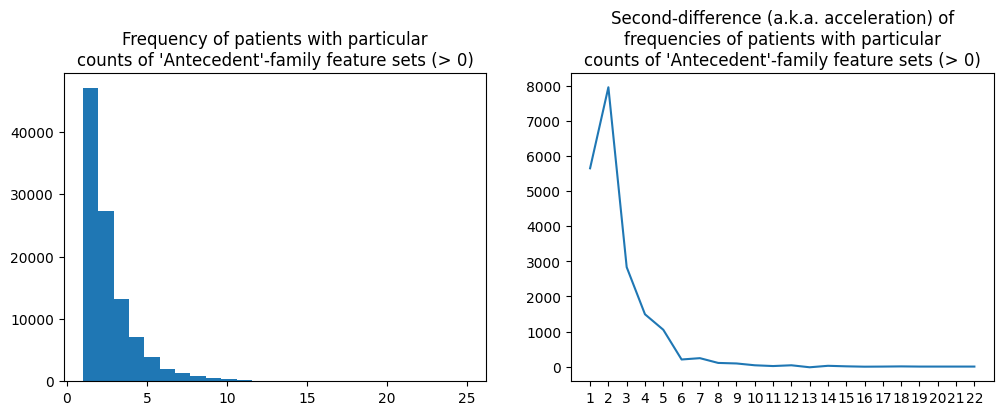

In [4]:
countvar = array_notNone_antecedent.sum(axis = 1)
countvar = countvar[countvar > 0]

# Plot parameters.
fig, axs = matplotlib.pyplot.subplots(1, 2, figsize = (12, 4))

# Raw count histogram
axs[0].hist(
    countvar
    ,bins = countvar.max().astype(int)
)
axs[0].set_title('Frequency of patients with particular\ncounts of \'Antecedent\'-family feature sets (> 0)')

# Line plot of 2nd-differences.
fd = countvar.value_counts().iloc[:-1].astype(int).to_numpy()
fd_lag = countvar.value_counts().iloc[1:].astype(int).to_numpy()
sd = (fd - fd_lag)[:-1]
sd_lag = (fd - fd_lag)[1:]
axs[1].plot(sd - sd_lag)
axs[1].set_title('Second-difference (a.k.a. acceleration) of\nfrequencies of patients with particular\ncounts of \'Antecedent\'-family feature sets (> 0)')
axs[1].set_xticks(numpy.arange(len(sd)), numpy.arange(1, len(sd)+1))

# Show plot.
matplotlib.pyplot.show()

Given the plots above:
- I choose the 'Few' region to be between 1 and 2, inclusive, based on the line plot of second-differences indicating an increased acceleration in the second data point. This corresponds to a marked acceleration at a count of 3. Therefore, the definition for 'Few' is {if >=1 and <=2 then True else False}.
- I choose the 'Some' region to be between 3 and 6, inclusive, based on the line plot of second-differences settling at the sixth data point. This corresponds to a regime of constant change in counts from a count of 7. Therefore, the definition for 'Some' is {if >=3 and <=6 then True else False}
- Given the definition of 'Some', the definition of 'Many' is {if >6 then True else False}.

Below, I create the feature sets.

In [5]:
few_antecedent = countvar.between(1,2)
some_antecedent = countvar.between(3,6)
many_antecedent = countvar > 6

## Create the 'Concurrent' family lists.

### Create the 'None' and 'Any' 'Concurrent' family lists.

In [6]:
# Define list of feature sets that are members of the 'Concurrent' family.
# ## The list of boolean members.
ls_concurrent_fs_bool = \
[
    'abandonment_Adult', 'ADHD_Adult', 'adultVictimOfAbuse', 'agorophobia_Adult',
    'alcoholMisuse_Adult', 'anxietyOrPanic_Adult', 'asylumSeeker_Adult', 'attemptedSuicide_Adult',
    'auditoryHallucinations_Adult',
    
    'bodyDysmorphicDisorder_Adult', 'brainInjury_Adult',
    
    'depressionNotDysthymiaOrChronic_Adult', 'dissociation_Adult', 'drugMisuse_Adult',
    
    'eatingDisorders_Adult', 'extremeSelfNeglect',
    
    'foodInsecurity_Adult',
    
    'historyOfOrCurrentAddiction', 'hoarder_Adult', 'homeless_Adult',
    
    'incarcerationImprisonment_Adult',
    
    'mentalHealthConcern_Adult', 'metabolicSyndrome_Adult',
    
    'NESA_Adult', 'nonNativeEnglishSpeaker',
    
    'OCD_Adult',
    
    'paranoia_Adult', 'poorBodyImage_Adult', 'poverty_Adult',
    
    'RecurringMentalSymptoms_Adult',
    
    'selfHarm_Adult', 'sleepDisturbance_Adult', 'sleepDysfunction_Adult',
    'socialServicesInvolved_Adult', 'substanceMisuse_Adult', 'suicidal_Adult',
    
    'tinnitus_Adult', 'tortured_Adult', 'trafficked_Adult',
    
    'UPSI_Adult',
    
    'violentBehaviour_Adult'
]
# ## The list of count members.
ls_concurrent_fs_count = \
[
    'countPsychologicalDisorders', 'socialServicesInvolvedCountOfCodes_Adult'
]
# ## The list of ordinal members.
# None.
# ## The list of continuous members.
# None.

# Create a pandas.DataFrame.Series that indicates the patient has at least one 'Concurrent' feature set.
array_notNone_concurrent =\
    pandas.concat(
                    [
                        feature_set_array[feature_set_array.columns.intersection(ls_concurrent_fs_count)] > feature_set_array[feature_set_array.columns.intersection(ls_concurrent_fs_count)].quantile(0.75),
                        feature_set_array[feature_set_array.columns.intersection(ls_concurrent_fs_bool)]
                    ],
                    axis = 1,
                )
notNone_concurrent = array_notNone_concurrent.any(True)
none_concurrent = ~notNone_concurrent

### Create the 'Few', 'Some', and 'Many' 'Concurrent' family lists.

I plot a histogram of patients' counts of 'Antecedent' feature sets. Hopefully, the boundaries between 'Few'-'Some' and 'Some'-'Many' will be obvious. In case they are not, and assuming the histogram density is a monotonically-decreasing function, I also plot the 2nd-difference (a.k.a. acceleration) plot and look for the point where the line settles. If the histogram density is not a monotonically-decreasing function, then I will justify a bespoke rule.

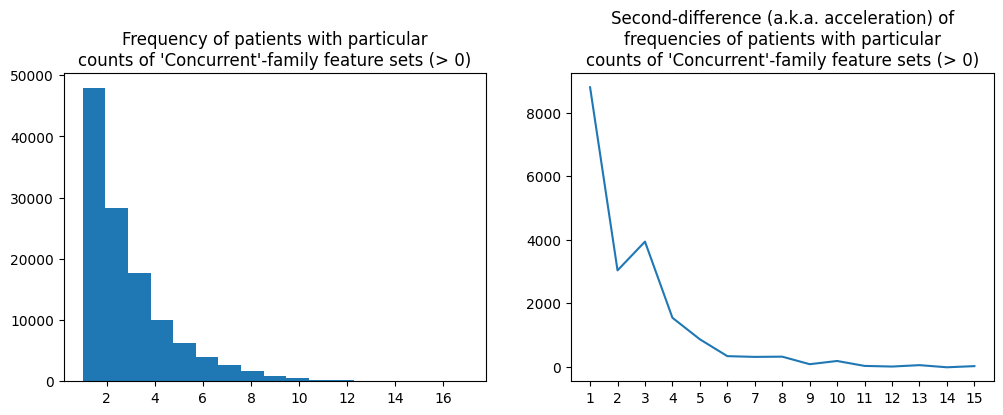

In [7]:
countvar = array_notNone_concurrent.sum(axis = 1)
countvar = countvar[countvar > 0]

# Plot parameters.
fig, axs = matplotlib.pyplot.subplots(1, 2, figsize = (12, 4))

# Raw count histogram
axs[0].hist(
    countvar
    ,bins = countvar.max().astype(int)
)
axs[0].set_title('Frequency of patients with particular\ncounts of \'Concurrent\'-family feature sets (> 0)')

# Line plot of 2nd-differences.
fd = countvar.value_counts().iloc[:-1].astype(int).to_numpy()
fd_lag = countvar.value_counts().iloc[1:].astype(int).to_numpy()
sd = (fd - fd_lag)[:-1]
sd_lag = (fd - fd_lag)[1:]
axs[1].plot(sd - sd_lag)
axs[1].set_title('Second-difference (a.k.a. acceleration) of\nfrequencies of patients with particular\ncounts of \'Concurrent\'-family feature sets (> 0)')
axs[1].set_xticks(numpy.arange(len(sd)), numpy.arange(1, len(sd)+1))


# Show plot.
matplotlib.pyplot.show()

Given the plots above:
- I choose the 'Few' region to be between 1 and 3, inclusive, based on the line plot of second-differences indicating an increased acceleration in the third data point. This corresponds to a marked acceleration at a count of 4. Therefore, the definition for 'Few' is {if >=1 and <=3 then True else False}.
- I choose the 'Some' region to be between 4 and 6, inclusive, based on the line plot of second-differences settling at the sixth data point. This corresponds to a regime of constant change in counts from a count of 7. Therefore, the definition for 'Some' is {if >=4 and <=6 then True else False}
- Given the definition of 'Some', the definition of 'Many' is {if >6 then True else False}.

Below, I create the feature sets.

In [8]:
few_concurrent = countvar.between(1,3)
some_concurrent = countvar.between(4,6)
many_concurrent = countvar > 6

## Create the 'Service Use' family lists.

### Create the 'None' and 'Any' 'Service Use' family lists.

In [9]:
# Define list of feature sets that are members of the 'Service Use' family.
# ## The list of boolean members.
ls_serviceUse_fs_bool = \
[
    'AccessToHealthcare_Adult', 'AccessToHealthcare_CYPA', 'AccessToHealthcare_EA',
    
    'firstAdmissionToPsychRehabServicesBefore30',
    
    'IAPTreferral_Adult', 'IAPTreferral_CYPA', 'IAPTreferral_EA',
    'IAPTrevolvingDoor_Adult', 'IAPTrevolvingDoor_CYPA', 'IAPTrevolvingDoor_EA',
    'IAPTuse_Adult', 'IAPTuse_CYPA', 'IAPTuse_EA',
    
    'manyDNA_Adult', 'manyDNA_CYPA', 'manyDNA_EA',   
]
# ## The list of count members.
# None
# ## The list of ordinal members.
ls_serviceUse_fs_ordinal = \
[
    'recurrentEDattendances_Adult', 'recurrentEDattendances_CYPA', 'recurrentEDattendances_EA'
]
# ## The list of continuous members.
ls_serviceUse_fs_continuous = \
[
    'ratioDNAtoAppointmentPreviousYear'
]

# Create a pandas.DataFrame.Series that indicates the patient has at least one 'Service Use' feature set.
array_notNone_serviceUse =\
    pandas.concat(
                    [
                        feature_set_array[feature_set_array.columns.intersection(ls_serviceUse_fs_bool)],
                        feature_set_array[feature_set_array.columns.intersection(ls_serviceUse_fs_ordinal)] != 'Infrequent',
                        feature_set_array[feature_set_array.columns.intersection(ls_serviceUse_fs_continuous)] > feature_set_array[feature_set_array.columns.intersection(ls_serviceUse_fs_continuous)].median()
                    ],
                    axis = 1,
                )
notNone_serviceUse = array_notNone_serviceUse.any(True)
none_serviceUse = ~notNone_serviceUse

### Create the 'Few', 'Some', and 'Many' 'Service Use' family lists.

I plot a histogram of patients' counts of 'Service Use' feature sets. Hopefully, the boundaries between 'Few'-'Some' and 'Some'-'Many' will be obvious. In case they are not, and assuming the histogram density is a monotonically-decreasing function, I also plot the 2nd-difference (a.k.a. acceleration) plot and look for the point where the line settles. If the histogram density is not a monotonically-decreasing function, then I will justify a bespoke rule.

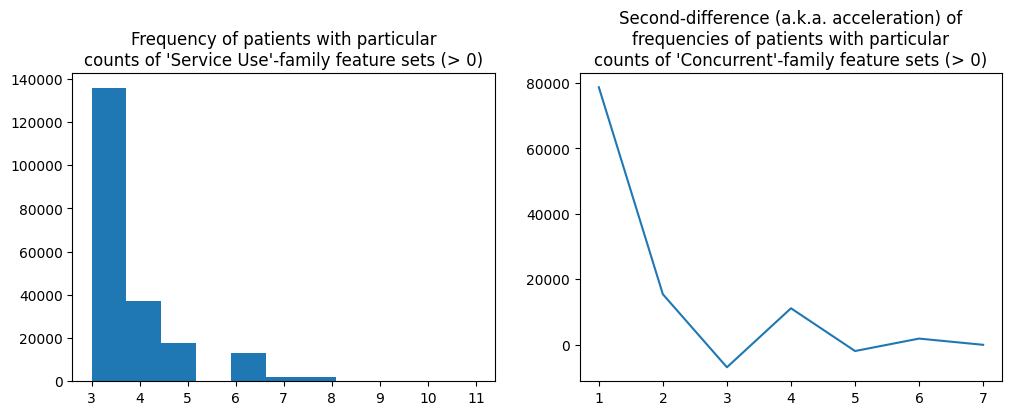

In [10]:
countvar = array_notNone_serviceUse.sum(axis = 1)
countvar = countvar[countvar > 0]

# Plot parameters.
fig, axs = matplotlib.pyplot.subplots(1, 2, figsize = (12, 4))

# Raw count histogram
axs[0].hist(
    countvar
    ,bins = countvar.max().astype(int)
)
axs[0].set_title('Frequency of patients with particular\ncounts of \'Service Use\'-family feature sets (> 0)')

# Line plot of 2nd-differences.
# Not used because the histogram does not display a monotonically-decreasing density.
#axs[1].set_title('IGNORE')
fd = countvar.value_counts().iloc[:-1].astype(int).to_numpy()
fd_lag = countvar.value_counts().iloc[1:].astype(int).to_numpy()
sd = (fd - fd_lag)[:-1]
sd_lag = (fd - fd_lag)[1:]
axs[1].plot(sd - sd_lag)
axs[1].set_title('Second-difference (a.k.a. acceleration) of\nfrequencies of patients with particular\ncounts of \'Concurrent\'-family feature sets (> 0)')
axs[1].set_xticks(numpy.arange(len(sd)), numpy.arange(1, len(sd)+1))


# Show plot.
matplotlib.pyplot.show()

Given the plots above:
- I choose the 'Few' region to be between 1 and 4, inclusive, based on the line plot of second-differences indicating an increased acceleration in the fourth data point. This corresponds to a marked acceleration at a count of 5. Therefore, the definition for 'Few' is {if >=1 and <=4 then True else False}.
- I choose the 'Some' region to be between 5 and 6, inclusive, based on the line plot of second-differences settling at the fifth data point. This corresponds to a regime of constant change in counts from a count of 6. Therefore, the definition for 'Some' is {if >=5 and <=6 then True else False}
- Given the definition of 'Some', the definition of 'Many' is {if >6 then True else False}.

Below, I create the feature sets.

In [11]:
few_serviceUse = countvar.between(1,4)
some_serviceUse = countvar.between(5, 6)
many_serviceUse = countvar > 6

## Create 'Treatment' family lists.

### Create 'None' and 'Any' 'Treatment' family lists.

In [12]:
# Define list of feature sets that are members of the 'Treatment' family.
# ## The list of bool members.
ls_treatment_fs_bool = \
[
    'MentalHealthTreatments_Adult', 'MentalHealthTreatments_CYPA', 'MentalHealthTreatments_EA'
]
# ## The list of count members.
ls_treatment_fs_count = \
[
    'countAntidepressantPrescriptions'
]
# ## The list of ordinal members.
# None.
# ## The list of continuous members.
# None.

# Create a pandas.DataFrame.Series that indicates the patient has at least one 'Treatment' feature set.
array_notNone_treatment =\
    pandas.concat(
                    [
                        feature_set_array[feature_set_array.columns.intersection(ls_treatment_fs_bool)],
                        feature_set_array[feature_set_array.columns.intersection(ls_treatment_fs_count)] > feature_set_array[feature_set_array.columns.intersection(ls_treatment_fs_count)].quantile(0.75),
                    ],
                    axis = 1,
                )
notNone_treatment = array_notNone_treatment.any(True)
none_treatment = ~notNone_treatment

### Create the 'Few', 'Some', and 'Many' 'Treatment' family lists.

I plot a histogram of patients' counts of 'Treatment' feature sets. Hopefully, the boundaries between 'Few'-'Some' and 'Some'-'Many' will be obvious. In case they are not, and assuming the histogram density is a monotonically-decreasing function, I also plot the 2nd-difference (a.k.a. acceleration) plot and look for the point where the line settles. If the histogram density is not a monotonically-decreasing function, then I will justify a bespoke rule.  

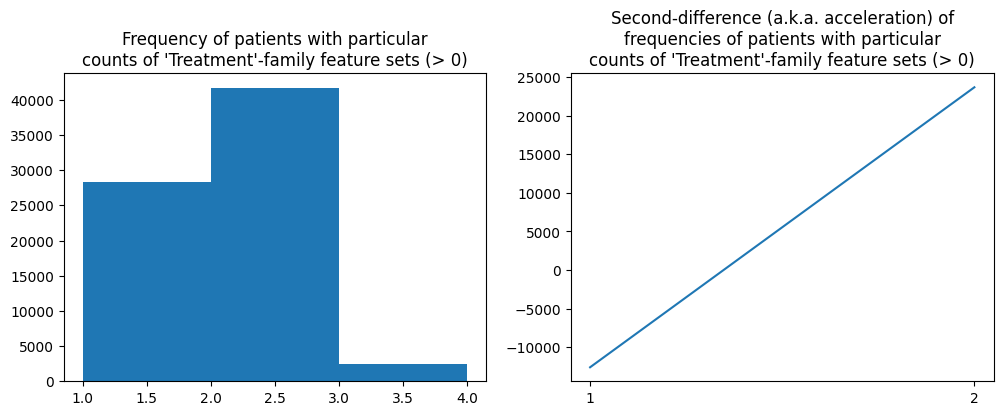

In [13]:
countvar = array_notNone_treatment.sum(axis = 1)
countvar = countvar[countvar > 0]

# Plot parameters.
fig, axs = matplotlib.pyplot.subplots(1, 2, figsize = (12, 4))

# Raw count histogram
axs[0].hist(
    countvar
    ,bins = 3#countvar.max().astype(int)
)
axs[0].set_title('Frequency of patients with particular\ncounts of \'Treatment\'-family feature sets (> 0)')

# Line plot of 2nd-differences.
fd = countvar.value_counts().iloc[:-1].astype(int).to_numpy()
fd_lag = countvar.value_counts().iloc[1:].astype(int).to_numpy()
sd = (fd - fd_lag)[:-1]
sd_lag = (fd - fd_lag)[1:]
axs[1].plot(sd - sd_lag)
axs[1].set_title('Second-difference (a.k.a. acceleration) of\nfrequencies of patients with particular\ncounts of \'Treatment\'-family feature sets (> 0)')
axs[1].set_xticks(numpy.arange(len(sd)), numpy.arange(1, len(sd)+1))

# Show plot.
matplotlib.pyplot.show()

Given the plots above:
- There are no patients with a value of zero, so I will not create the 'None' version of this family.
- I choose the 'Few' to be 1, based on the raw counts. Therefore, the definition for 'Few' is {if 1 then True else False}.
- I choose the 'Some' to be 2, based on the raw counts. Therefore, the definition for 'Some' is {if 2 then True else False}.
- Given the definition of 'Some', the definition of 'Many' is {if 3 then True else False}.

Below, I create the feature sets.

In [14]:
few_treatment = countvar == 1
some_treatment = countvar == 2
many_treatment = countvar == 3

## Create 'Chaotic' family lists.

### Create the 'None' and 'Any' 'Chaotic' family lists.

In [2]:
# Define list of feature sets that are members of the 'Chaotic' family.
# ## The list of boolean members.
# None
# ## The list of count members.
ls_chaotic_fs_count = \
[
    'countAppointmentsPreviousYear', 'countDNAsPreviousYear',
    
    'medianAnnualCountAppointments', 'medianAnnualCountAppointments_Adult',
    'medianAnnualCountAppointments_CYPA', 'medianAnnualCountDNAs', 'medianAnnualCountDNAs_Adult',
    'medianAnnualCountDNAs_CYPA', 'medianAnnualCountDNAs_EA'
]
# ## The list of ordinal members.
# None.
# ## The list of continuous members.
ls_chaotic_fs_continuous = \
[
    'activeInformationAppointments', 'activeInformationDNAs', 'activeInformationMHcrises',
    
    'bubbleEntropyAppointments', 'bubbleEntropyDNAs', 'bubbleEntropyMHcrises',
    
    'entropyRateAppointments', 'entropyRateDNAs', 'entropyRateMHcrises',
    'eoeAppointments', 'eoeDNAs', 'eoeMHcrises',
    
    'medianAnnualRatioDNAtoAppointment', 'medianAnnualRatioDNAtoAppointment_Adult',
    'medianAnnualRatioDNAtoAppointment_CYPA', 'medianAnnualRatioDNAtoAppointment_EA',
    
    'sampleEntropyAppointments', 'sampleEntropyDNAs', 'sampleEntropyMHcrises',
    'spectralEntropyAppointments', 'spectralEntropyDNAs', 'spectralEntropyMHcrises'
]

# Create a pandas.DataFrame.Series that indicates the patient has at least one 'Concurrent' feature set.
array_notNone_chaotic =\
    pandas.concat(
                    [
                        feature_set_array[feature_set_array.columns.intersection(ls_chaotic_fs_count)] > feature_set_array[feature_set_array.columns.intersection(ls_chaotic_fs_count)].quantile(0.75),
                        feature_set_array[feature_set_array.columns.intersection(ls_chaotic_fs_continuous)] > feature_set_array[feature_set_array.columns.intersection(ls_chaotic_fs_continuous)].median()
                    ],
                    axis = 1,
                )
notNone_chaotic = array_notNone_chaotic.any(True)
none_chaotic = ~notNone_chaotic

### Create the 'Few', 'Some', and 'Many' 'Chaotic' family lists.

I plot a histogram of patients' counts of 'Chaotic' feature sets. Hopefully, the boundaries between 'Few'-'Some' and 'Some'-'Many' will be obvious. In case they are not, and assuming the histogram density is a monotonically-decreasing function, I also plot the 2nd-difference (a.k.a. acceleration) plot and look for the point where the line settles. If the histogram density is not a monotonically-decreasing function, then I will justify a bespoke rule.

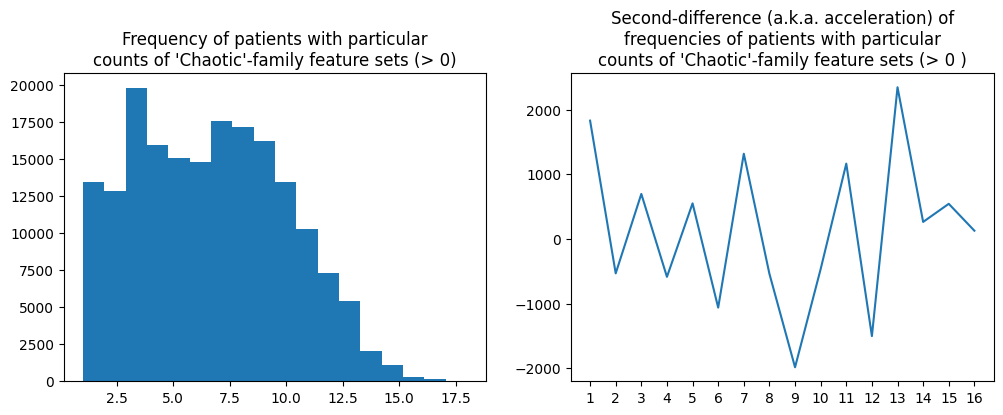

In [3]:
countvar = array_notNone_chaotic.sum(axis = 1)
countvar = countvar[countvar > 0]

# Plot parameters.
fig, axs = matplotlib.pyplot.subplots(1, 2, figsize = (12, 4))

# Raw count histogram
axs[0].hist(
    countvar
    ,bins = countvar.max().astype(int)
)
axs[0].set_title('Frequency of patients with particular\ncounts of \'Chaotic\'-family feature sets (> 0)')

# Line plot of 2nd-differences.
fd = countvar.value_counts().iloc[:-1].astype(int).to_numpy()
fd_lag = countvar.value_counts().iloc[1:].astype(int).to_numpy()
sd = (fd - fd_lag)[:-1]
sd_lag = (fd - fd_lag)[1:]
axs[1].plot(sd - sd_lag)
axs[1].set_title('Second-difference (a.k.a. acceleration) of\nfrequencies of patients with particular\ncounts of \'Chaotic\'-family feature sets (> 0 )')
axs[1].set_xticks(numpy.arange(len(sd)), numpy.arange(1, len(sd)+1))

# Show plot.
matplotlib.pyplot.show()

Given the lack of obvious thresholds in the plots above:
- I choose the 'Few' region to be anything less than or equal to the lower 33rd percentile of values.
- I choose the 'Some' region to be anything greater than the lower 33rd percentile of values but less than or equal to the 66th percentile of values.
- I choose the 'Many' region to be anything greater than the 66th percentile of values.

Below, I create the feature sets.

In [17]:
# Given the skewed-normal distribution, I opt for a quantile split.
few_chaotic = countvar <= countvar.quantile(0.33)
some_chaotic = countvar.between(countvar.quantile(0.33),countvar.quantile(0.66), inclusive = "right")
many_chaotic = countvar > countvar.quantile(0.66)

## Create 'Patterns of Prescription' family lists.

### Create the 'None' and 'Any' 'Patterns of Prescription' family lists.

In [18]:
# Define list of feature sets that are members of the 'Patterns of Prescription' family.
# ## The list of boolean members.
# None
# ## The list of count members.
ls_patternsOfPrescriptions_fs_count = \
[
    'countAbortedAntidepressantMedicationRegimes', 'countHypnoticsAndAnxiolyticsPrescriptions',
    'countUniqueAntidepressants', 'countUniqueHypnoticsAndAnxiolytics'
]
# ## The list of ordinal members.
# None
# ## The list of continuous members.
# None

# Create feature set that indicates the patient has at least one 'Patterns of Prescription' feature set.
array_notNone_patternsOfPrescriptions =\
    pandas.concat(
                    [
                        feature_set_array[feature_set_array.columns.intersection(ls_patternsOfPrescriptions_fs_count)] > feature_set_array[feature_set_array.columns.intersection(ls_patternsOfPrescriptions_fs_count)].quantile(0.75),
                    ],
                    axis = 1,
                )
notNone_patternsOfPrescriptions = array_notNone_patternsOfPrescriptions.any(True)
none_patternsOfPrescriptions = ~notNone_patternsOfPrescriptions

### Create the 'Few', 'Some', and 'Many' 'Patterns of Prescriptions' family lists.

I plot a histogram of patients' counts of 'Patterns of Prescriptions' feature sets. Hopefully, the boundaries between 'Few'-'Some' and 'Some'-'Many' will be obvious. In case they are not, and assuming the histogram density is a monotonically-decreasing function, I also plot the 2nd-difference (a.k.a. acceleration) plot and look for the point where the line settles. If the histogram density is not a monotonically-decreasing function, then I will justify a bespoke rule.

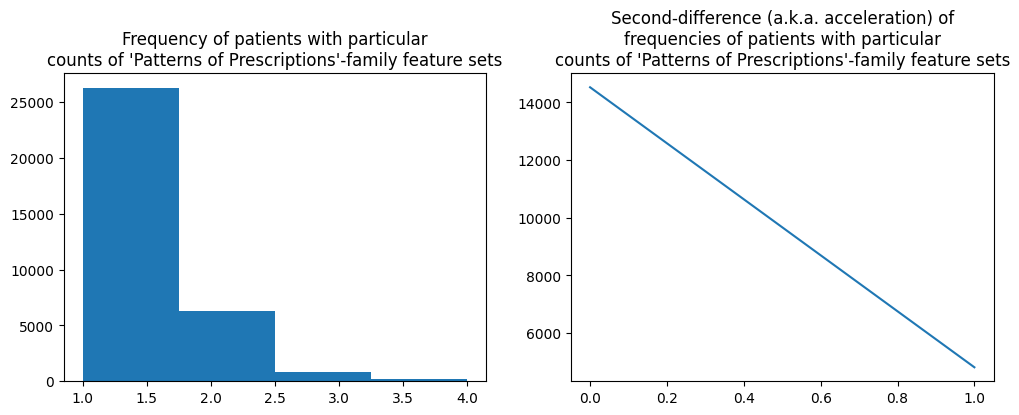

In [19]:
countvar = array_notNone_patternsOfPrescriptions.sum(axis = 1)
countvar = countvar[countvar > 0]

# Plot parameters.
fig, axs = matplotlib.pyplot.subplots(1, 2, figsize = (12, 4))

# Raw count histogram
axs[0].hist(
    countvar
    ,bins = countvar.max().astype(int)
)
axs[0].set_title('Frequency of patients with particular\ncounts of \'Patterns of Prescriptions\'-family feature sets')

# Line plot of 2nd-differences.
fd = countvar.value_counts().iloc[:-1].astype(int).to_numpy()
fd_lag = countvar.value_counts().iloc[1:].astype(int).to_numpy()
sd = (fd - fd_lag)[:-1]
sd_lag = (fd - fd_lag)[1:]
axs[1].plot(sd - sd_lag)
axs[1].set_title('Second-difference (a.k.a. acceleration) of\nfrequencies of patients with particular\ncounts of \'Patterns of Prescriptions\'-family feature sets')

# Show plot.
matplotlib.pyplot.show()

Given the plots above:
- I choose the 'Few' region to be between 1 and 4, inclusive, based on the line plot of second-differences indicating an increased acceleration in the fourth data point. This corresponds to a marked acceleration at a count of 5. Therefore, the definition for 'Few' is {if >=1 and <=4 then True else False}.
- I choose the 'Some' region to be between 5 and 6, inclusive, based on the line plot of second-differences settling at the fifth data point. This corresponds to a regime of constant change in counts from a count of 6. Therefore, the definition for 'Some' is {if >=5 and <=6 then True else False}
- Given the definition of 'Some', the definition of 'Many' is {if >6 then True else False}.

Below, I create the feature sets.

In [20]:
few_patternsOfPrescriptions = countvar <= 2
some_patternsOfPrescriptions = countvar.between(3,4)
many_patternsOfPrescriptions = countvar > 4

## Create 'Relevant Prescriptions' family lists.

### Create 'None' and 'Any' 'Relevant Prescriptions' family lists.

In [21]:
# Define list of feature sets that are members of the 'Relevant Prescriptions' family.
# ## The list of boolean members.
ls_relevantPrescriptions_fs_bool = \
[
    'relevantPrescriptions_Adult', 'relevantPrescriptions_CYPA', 'relevantPrescriptions_EA'
]
# ## The list of count members.
# None
# ## The list of ordinal members.
# None
# ## The list of continuous members.
# None

# Create feature set that indicates the patient has at least one 'Relevant Prescriptions' feature set.
array_notNone_relevantPrescriptions =\
    pandas.concat(
                    [
                        feature_set_array[feature_set_array.columns.intersection(ls_relevantPrescriptions_fs_bool)]
                    ],
                    axis = 1,
                )
notNone_relevantPrescriptions = array_notNone_relevantPrescriptions.any(True)
none_relevantPrescriptions = ~ notNone_relevantPrescriptions

### Create the 'Few', 'Some', and 'Many' 'Relevant Prescriptions' family lists.

I plot a histogram of patients' counts of 'Relevant Prescriptions' feature sets. Hopefully, the boundaries between 'Few'-'Some' and 'Some'-'Many' will be obvious. In case they are not, and assuming the histogram density is a monotonically-decreasing function, I also plot the 2nd-difference (a.k.a. acceleration) plot and look for the point where the line settles. If the histogram density is not a monotonically-decreasing function, then I will justify a bespoke rule. 

 

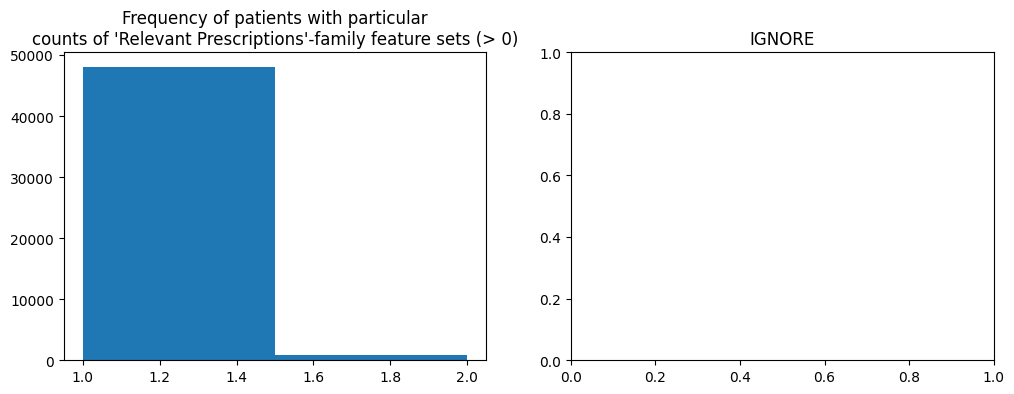

In [22]:
countvar = array_notNone_relevantPrescriptions.sum(axis = 1)
countvar = countvar[countvar > 0]

# Plot parameters.
fig, axs = matplotlib.pyplot.subplots(1, 2, figsize = (12, 4))

# Raw count histogram
axs[0].hist(
    countvar
    ,bins = countvar.max().astype(int)
)
axs[0].set_title('Frequency of patients with particular\ncounts of \'Relevant Prescriptions\'-family feature sets (> 0)')

# Line plot of 2nd-differences.
axs[1].set_title('IGNORE')
# Not used because there are too few unique values.

# Show plot.
matplotlib.pyplot.show()

Raw counts show that only two values are present: {1, 2}. Therefore, I'll only make 'Few' and 'Some' versions of this family.

Below, I create the feature sets.

In [23]:
few_relevantPrescriptions = countvar == 1
some_relevantPrescriptions = countvar == 2

## Create 'Antipsychotic prescriptions' family lists.

### Create the 'None' and 'Any' 'Patterns of Prescription' family lists.

In [24]:
# Define list of feature sets that are members of the 'Antipsychotic Prescription' family.
notNone_antipsychoticsPrescription = feature_set_array.antipsychoticsPrescription
none_antipsychoticsPrescription = ~notNone_antipsychoticsPrescription

# Combine the 'at least' lists.

Each of the lists created above indicate that the patient belongs _at least_ to a given family, but does not indicate exclusive belonging to a family or combination of families. To calculate the feature sets that represent these various, exclusive memberships, I combine the lists into a `pandas.Dataframe`. The next feature-set appendix notebook will then create each of the feature sets that represent these various, exclusive memberships.

In [25]:
nafsm_family_membership = \
    pandas.DataFrame(
        data = {
            'person_id' : feature_set_array.person_id,
            
            'none_antecedent' : none_antecedent,
            'none_concurrent' : none_concurrent,
            'none_serviceUse' : none_serviceUse,
            'none_treatment' : none_treatment,
            'none_chaotic' : none_chaotic,
            'none_patternsOfPrescription' : none_patternsOfPrescriptions,
            #'none_relevantPrescriptions' : none_relevantPrescriptions, # No 'None' category.
            'none_antipsychoticsPrescription' : none_antipsychoticsPrescription,
            
            'notNone_antecedent' : notNone_antecedent,
            'notNone_concurrent' : notNone_concurrent,
            'notNone_serviceUse' : notNone_serviceUse,
            'notNone_treatment' : notNone_treatment,
            'notNone_chaotic' : notNone_chaotic,
            'notNone_patternsOfPrescription' : notNone_patternsOfPrescriptions,
            'notNone_relevantPrescriptions' : notNone_relevantPrescriptions,
            'notNone_antipsychoticsPrescription' : notNone_antipsychoticsPrescription,
            
            'few_antecedent' : few_antecedent,
            'few_concurrent' : few_concurrent,
            'few_serviceUse' : few_serviceUse,
            'few_treatment' : few_treatment,
            'few_chaotic' : few_chaotic,
            'few_patternsOfPrescription' : few_patternsOfPrescriptions,
            'few_relevantPrescriptions' : few_relevantPrescriptions,
            
            'some_antecedent' : some_antecedent,
            'some_concurrent' : some_concurrent,
            'some_serviceUse' : some_serviceUse,
            'some_treatment' : some_treatment,
            'some_chaotic' : some_chaotic,
            'some_patternsOfPrescription' : some_patternsOfPrescriptions,
            'some_relevantPrescriptions' : some_relevantPrescriptions,
            
            'many_antecedent': many_antecedent,
            'many_concurrent': many_concurrent,
            'many_serviceUse': many_serviceUse,
            'many_treatment': many_treatment,
            'many_chaotic': many_chaotic,
            'many_patternsOfPrescription': many_patternsOfPrescriptions,
            #'many_relevantPrescriptions': many_relevantPrescriptions # No 'Many' category.
            
        }
)
%store nafsm_family_membership

Stored 'nafsm_family_membership' (DataFrame)
